# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [120]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [121]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import Isomap

from seaborn import heatmap

from IPython.display import display, HTML

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [122]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [123]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [124]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32, 3)


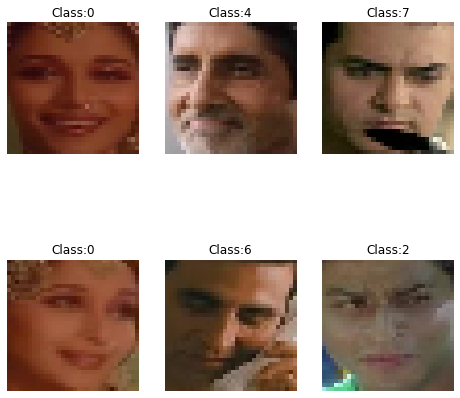

In [125]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [126]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [127]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k, pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [128]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree, fit_inverse_transform = True)
    X_k = kpca.fit_transform(X)
    return X_k, kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [129]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k, lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [130]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X_transformed,y)
    return X_k, klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [131]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [132]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces?

___________________________

*Eigen faces are eigen vectors which are derived from the covarinace matrix of the high dimensional vector space of face images. The eigen faces form a set of basis features, which can be linearly combined to reconstruct images in the original training set.
For obtaining the eigen faces, we perform Principal Component Analysis(PCA) on a dataset of say N images represented in D dimensions. We use the first M eigen vectors corresponding to M largest eigen values obtained from PCA as our basis features in the low dimensional space in M dimensions.
On reshaping these eigen vectors into the dimensions of the original images, we obtain the eigen faces.*


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.
______________________________________

*The ideal number of eigen faces, minimzing the number of components in the lower dimension is as follows:*
- *IMFDB*
    - *Good reconstruction - 135 eigen faces*
    - *Covered varinace - ~96%*
    - *Reconstruction error - ~0.036*
- *IIIT-CFW*
    - *Good reconstruction - 400 eigen faces*
    - *Covered varinace - ~98%*
    - *Reconstruction error - ~0.047* 
- *Yale Face Database*
    - *Good reconstruction - 75 eigen faces*
    - *Covered varinace - ~97%*
    - *Reconstruction error - ~0.045*
    
*Based on the eigen value spectrum, we can observe that majority of the covariance is captured in :*
 - *IMFDB*
  - *Approximately the first 20 eigen vectors*
 - *IIIT-CFW*
  - *Approximately the first 10 eigen vectors*
 - *Yale Face Database*
  - *Approximately the first 20 eigen vectors*

In [133]:
imfdb_name = './dataset/IMFDB/'
iiit_cfw_name = './dataset/IIIT-CFW/'
yale_face_database_name = './dataset/Yale_face_database/'

In [134]:
# Compute your features
if dirpath == imfdb_name:
    pca, pca_model = get_pca(X, 135)
    kernel_pca, kernel_pca_model = get_kernel_pca(X, 20, "poly", 20)
    lda, _ = get_lda(X, y, 135)
    kernel_lda, _ = get_kernel_lda(X, y, 100, "poly", 17)
elif dirpath == iiit_cfw_name:
    pca, pca_model = get_pca(X, 400)
    kernel_pca, kernel_pca_model = get_kernel_pca(X, 55, "poly", 14)
    lda, _ = get_lda(X, y, 135)
    kernel_lda, _ = get_kernel_lda(X, y, 100, "poly", 17)
elif dirpath == yale_face_database_name:
    pca, pca_model = get_pca(X, 75)
    kernel_pca, kernel_pca_model = get_kernel_pca(X, 15, "poly", 15)
    lda, _ = get_lda(X, y, 135)
    kernel_lda, _ = get_kernel_lda(X, y, 100, "poly", 17)
comp_projection, comp_model = get_pca(X, N)
eigenvalues = comp_model.explained_variance_
perc = (np.sum(pca_model.explained_variance_) / np.sum(eigenvalues)) * 100
print('Percentage of variance covered: {0}'.format(perc))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\decomposition\kernel_pca.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=1.08062e-48): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\decomposition\kernel_pca.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=1.08062e-48): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3072, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller 

Percentage of variance covered: 95.5988589722688


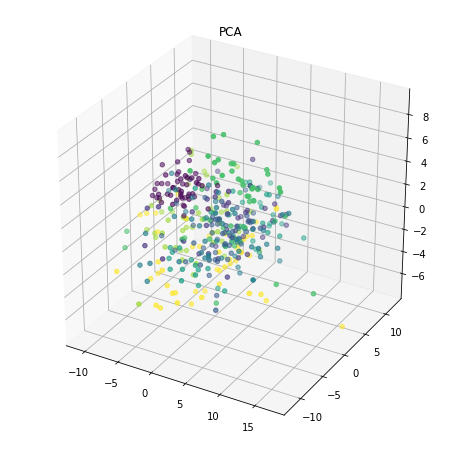

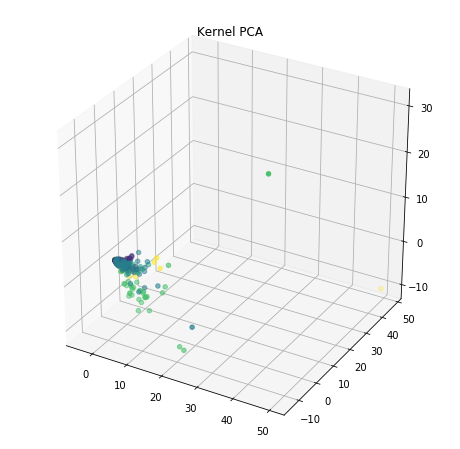

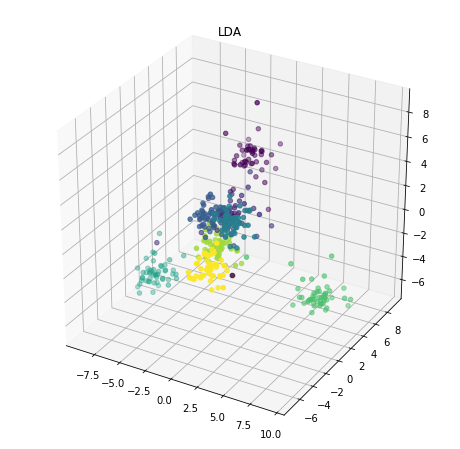

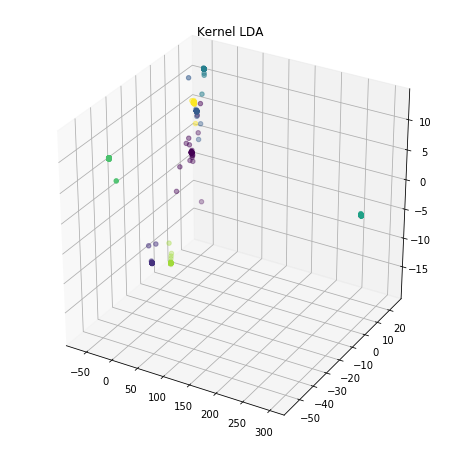

In [135]:
# Create a scatter plot  
# PCA
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca[:,0], pca[:,1], pca[:,2],c=y)
plt.title("PCA")
plt.show()

# Kernel PCA
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kernel_pca[:,0], kernel_pca[:,1], kernel_pca[:,2],c=y)
plt.title("Kernel PCA")
plt.show()

# LDA
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lda[:,0], lda[:,1], lda[:,2],c=y)
plt.title("LDA")
plt.show()

# Kernel LDA
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kernel_lda[:,0], kernel_lda[:,1], kernel_lda[:,2],c=y)
plt.title("Kernel LDA")
plt.show()

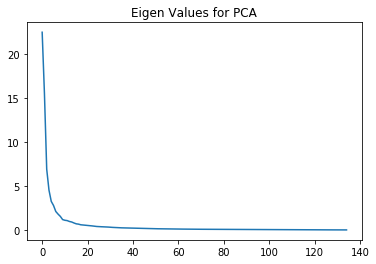

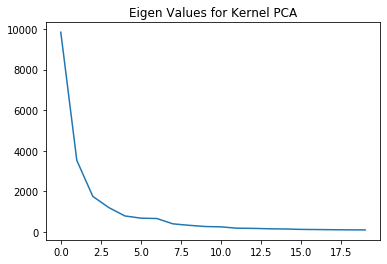

In [136]:
# Plot the eigen value spectrum
# PCA
eigen_values_pca = pca_model.explained_variance_
plt.plot(eigen_values_pca)
plt.title("Eigen Values for PCA")
plt.show()

# Kernel PCA
eigen_values_kernel_pca = kernel_pca_model.lambdas_
plt.plot(eigen_values_kernel_pca)
plt.title("Eigen Values for Kernel PCA")
plt.show()


1(c). Reconstruct  the  image  back for each case


In [137]:
def reconstruct_images(X, reduction_model):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    reconstruct_X = reduction_model.inverse_transform(X)
    
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


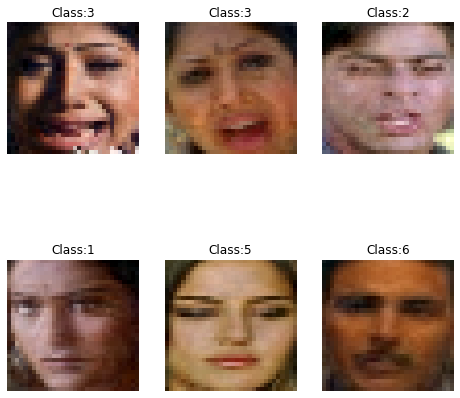

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE Error of PCA: 0.036228791014134405


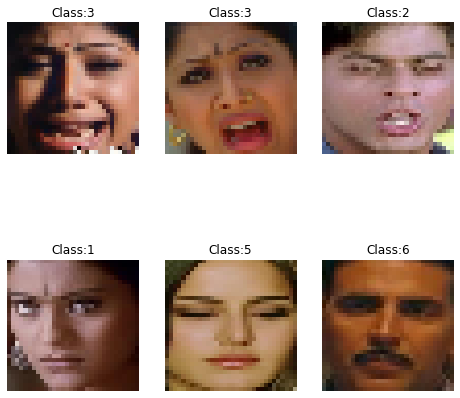

MSE Error of Kernel PCA: 0.008824495186806426


In [138]:
# PCA
# Display results 
X_reconstructed = reconstruct_images(pca, pca_model)

# Display random images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_reconstructed.reshape(N, H, W, C)[ind,...],y[ind],row=2,col=3)

# Show the reconstruction error
print("MSE Error of PCA: {}".format(np.sqrt(np.mean((X - X_reconstructed)**2))))

# Kernel PCA
# Display results 
X_reconstructed = reconstruct_images(kernel_pca, kernel_pca_model)

# Display random images
disply_images(X_reconstructed.reshape(N, H, W, C)[ind,...],y[ind],row=2,col=3)

# Show the reconstruction error
print("MSE Error of Kernel PCA: {}".format(np.sqrt(np.mean((X - X_reconstructed)**2))))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [139]:
# code goes here
mse = []
for i in np.unique(y):
    mse.append(np.sqrt(np.mean((X[y == i] - X_reconstructed[y == i])**2)))
print("Class with maximum error : {}".format(np.argmax(np.array(mse))))
print("Class with minimum error : {}".format(np.argmin(np.array(mse))))

for i in np.unique(y):
    print("Error corresponding to Class {0} : {1}".format(i, mse[i]))

Class with maximum error : 1
Class with minimum error : 4
Error corresponding to Class 0 : 0.00494512704660996
Error corresponding to Class 1 : 0.012304605171937506
Error corresponding to Class 2 : 0.010657526651943458
Error corresponding to Class 3 : 0.00612115035931326
Error corresponding to Class 4 : 0.0016284017486814482
Error corresponding to Class 5 : 0.00995362339666676
Error corresponding to Class 6 : 0.007707002311902414
Error corresponding to Class 7 : 0.011616392761942831


*The classes that are hard to classify with minimum number of eigen vectors for each of the datasets are as follows:*
- *IMFDB*
 - *Kajol is the worst in IMFDB because there are a lot of blurry images in the dataset, and the features of the face are very distinct in each image, making it hard to classify and with the maximum reconstruction loss*
- *IIIT-CFW*
 - *Dwayne Johnson is the worst in IIIT because the images vary a lot, with some images having extremely elongated faces, and others with some other altered feature, making it hard to classify, and the one with maximum reconstruction loss*
- *Yale Face Database*
 - *Class 1 is the worst in Yale database because the shadows in the class are very dark and the pictures of this class are mostly dark. The man in the class has a moustache, hence making the face of the man hard to reconstruct, and this class to be the one with the maximum reconstruction loss*
____________________________

*The dataset that is the hardest to classify is the IIIT cartoon dataset. We can see from the eigen value spectrum, that the rate of drop of eigen values is slower in this dataset compared to the other two datasets. More eigen vectors are required to preserve more than 95% variance of the dataset, hence making it the most difficult to classify in fewer eigen vectors. The cartoon dataset has the highest average reconstruction loss, since the images within a class are highly, showing high variations in intensities, adn other aspects. 
This leads to difficulty in classifying it compactly.*

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

*For the purpose of classification, I ahve used Multi-Layer Perceptron Classifier. Using the MLP Classifier, we first perform the split in the dataset to create test and training data. Then we perfrom dimensionality reduction on the training data to obtain a reduced matrix, that transforms features from the original space to a lower dimensional space. We train the classifier on the reduced features. While testing, we transform the test data into a lower dimension, using the above mentioned reduced matrix, and then perform the classification on this reduced dimensional space, We have checked this accuracy after training on the following reduced features - PCA, Kernel PCA, LDA, Kernel LDA, VGG, Resnet*
__________________________________________

2(b). Which method works well? Do a comparitivestudy. 
You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

*As we can see in the results given below, Resnet gives the best results in all the three datasets, with accuracies greater than 95%. This is because Resnet transforms the features into a higher dimensional space, allowing non-linearity in the representation, making accuracy much better. LDA does fairly well on IMFDB and Yale datasets (70%-89%) , but very poorly on IIIT dataset. PCA and Kernel PCA are decent on IMFDB and Yale datsets (70%-90%), but poor on IIIT dataset. Kernel LDA is poor with all the datsets. VGG is good on IMFDB dataset and decent on the other two datasets*

In [140]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self, hidden_size, activation):
        super(Classifier, self).__init__()
        self.classifier = MLPClassifier(hidden_size, activation = activation, max_iter = 1000)
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.classifier.predict(X)
        
        return prediction
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        predictions = self.classifier.predict(X)
        verification_results = (class_id == predictions)
        return verification_results
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        self.conf_matrix = confusion_matrix(y, pred)
        return self.conf_matrix
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classifier.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """

        # Create a confusion matrix
        predictions = self.classify(X_validate)
        conf_matrix = self.confusion_matrix(predictions, y_validate)
        
        # Calculate Classification Error
        classification_error = 0
        for i in range(len(predictions)):
            if predictions[i] != y_validate[i]:
                classification_error += 1
        # Calculate Validation accuracy 
        validation_accuracy = accuracy_score(y_validate, predictions)

        # Calculate precision and recall 
        precision, recall, _, _ = precision_recall_fscore_support(y_validate, predictions)
      
        # Calculate F1-score
        f_score = f1_score(y_validate, predictions, average='weighted')
        
        return conf_matrix, validation_accuracy, precision, recall, f_score, classification_error

In [141]:
# Create a train and validation split to train your classifier 
if dirpath == imfdb_name:
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    # PCA
    pca_X_train, pca_model = get_pca(X_train, 135)
    pca_X_test = pca_model.transform(X_test)
    # Kernel PCA
    kernel_pca_X_train, kernel_pca_model = get_kernel_pca(X_train, 20, "poly", 20)
    kernel_pca_X_test = kernel_pca_model.transform(X_test)
    # LDA
    lda_X_train, lda_model = get_lda(X_train, y_train, 135)
    lda_X_test = lda_model.transform(X_test)
    # Kernel_LDA
    kernel_lda_X_train, kernel_lda_model = get_kernel_lda(X_train, y_train, 100, "poly", 17)
    kernel_lda_X_test = kernel_lda_model.transform(X_test)
    # Resnet
    resnet_data = get_resnet_features(dirpath)
    resnet_X_train, resnet_X_test, resnet_y_train, resnet_y_test = train_test_split(resnet_data, y)
    # VGG
    vgg_data = get_vgg_features(dirpath)
    vgg_X_train, vgg_X_test, vgg_y_train, vgg_y_test = train_test_split(vgg_data, y)

if dirpath == iiit_cfw_name:
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    # PCA
    pca_X_train, pca_model = get_pca(X_train, 185)
    pca_X_test = pca_model.transform(X_test)
    # Kernel PCA
    kernel_pca_X_train, kernel_pca_model = get_kernel_pca(X_train, 55, "poly", 14)
    kernel_pca_X_test = kernel_pca_model.transform(X_test)
    # LDA
    lda_X_train, lda_model = get_lda(X_train, y_train, 135)
    lda_X_test = lda_model.transform(X_test)
    # Kernel_LDA
    kernel_lda_X_train, kernel_lda_model = get_kernel_lda(X_train, y_train, 100, "poly", 17)
    kernel_lda_X_test = kernel_lda_model.transform(X_test)
    # Resnet
    resnet_data = get_resnet_features(dirpath)
    resnet_X_train, resnet_X_test, resnet_y_train, resnet_y_test = train_test_split(resnet_data, y)
    # VGG
    vgg_data = get_vgg_features(dirpath)
    vgg_X_train, vgg_X_test, vgg_y_train, vgg_y_test = train_test_split(vgg_data, y)

if dirpath == yale_face_database_name:
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    # PCA
    pca_X_train, pca_model = get_pca(X_train, 75)
    pca_X_test = pca_model.transform(X_test)
    # Kernel PCA
    kernel_pca_X_train, kernel_pca_model = get_kernel_pca(X_train, 25, "poly", 15)
    kernel_pca_X_test = kernel_pca_model.transform(X_test)
    # LDA
    lda_X_train, lda_model = get_lda(X_train, y_train, 135)
    lda_X_test = lda_model.transform(X_test)
    # Kernel_LDA
    kernel_lda_X_train, kernel_lda_model = get_kernel_lda(X_train, y_train, 100, "poly", 17)
    kernel_lda_X_test = kernel_lda_model.transform(X_test)
    # Resnet
    resnet_data = get_resnet_features(dirpath)
    resnet_X_train, resnet_X_test, resnet_y_train, resnet_y_test = train_test_split(resnet_data, y)
    # VGG
    vgg_data = get_vgg_features(dirpath)
    vgg_X_train, vgg_X_test, vgg_y_train, vgg_y_test = train_test_split(vgg_data, y)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\decomposition\kernel_pca.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=1.69488e-48): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\decomposition\kernel_pca.py:257: LinAlgWarning: Ill-conditioned matrix (rcond=1.69488e-48): result may not be accurate.
  self.dual_coef_ = linalg.solve(K, X, sym_pos=True, overwrite_a=True)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(3072, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller 

In [142]:
training_data = [pca_X_train, kernel_pca_X_train, lda_X_train, kernel_lda_X_train, resnet_X_train, vgg_X_train]
testing_data = [pca_X_test, kernel_pca_X_test, lda_X_test, kernel_lda_X_test, resnet_X_test, vgg_X_test]
label_data_train = [y_train, y_train, y_train, y_train, resnet_y_train, vgg_y_train]
label_data_test = [y_test, y_test, y_test, y_test, resnet_y_test, vgg_y_test]
confusion_matrices = []
validation_accuracies = []
precisions = []
recalls = []
f1_scores = []
classification_errors = []

for i in range(len(training_data)):
    classifier = Classifier(hidden_size = (100, 250, 40), activation = "tanh" )
    classifier.train(training_data[i], label_data_train[i])
    c, v, p, r, f, e = classifier.validate(testing_data[i], label_data_test[i])
    confusion_matrices.append(c)
    validation_accuracies.append(v)
    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f)
    classification_errors.append(e)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [143]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. np.array(You can use Pandas)
feature_names = ['PCA', 'Kernel PCA', 'LDA', 'Kernel LDA', 'Resnet', 'VGG']
confusion_matrices = np.array(confusion_matrices)
validation_accuracies = np.array(validation_accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)
classification_errors = np.array(classification_errors)

In [145]:
if dirpath == yale_face_database_name:
    yale_face_database_table = pd.DataFrame({
        'Feature': feature_names,
        'Dimensionality': [pca_X_train.shape[1], kernel_pca_X_train.shape[1], lda_X_train.shape[1], kernel_lda_X_train.shape[1], resnet_X_train.shape[1], vgg_X_train.shape[1]],
        'Error': classification_errors,
        'Accuracy': validation_accuracies,
        'F1 Score': f1_scores
    })
    print('Yale Face Database:')
    display((yale_face_database_table))
    print(confusion_matrices[4])
    plt.figure(figsize=(10,7))
    heatmap(confusion_matrices[4], annot=True)
    plt.show()
    print('Above is Confusion Matrix for Resnet')

IMFDB: 


,Feature,Dimensionality,Error,Accuracy,F1 Score
0,PCA,135,25,0.75,0.748829
1,Kernel PCA,20,32,0.68,0.673420
2,LDA,7,28,0.72,0.719468
3,Kernel LDA,7,85,0.15,0.077437
4,Resnet,2048,5,0.95,0.950280
5,VGG,4096,15,0.85,0.847931


[[ 8  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  1  0  0]
 [ 0  0 12  0  0  0  0  0]
 [ 0  0  0  6  0  1  0  0]
 [ 0  0  1  0 15  0  0  0]
 [ 0  0  0  0  0 14  0  0]
 [ 0  0  1  0  0  0 15  1]
 [ 0  0  0  0  0  0  0 12]]


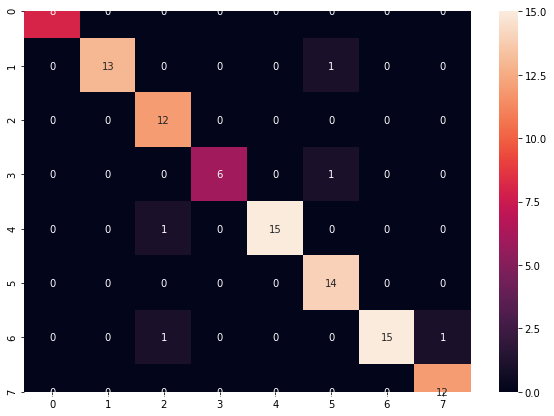

Above is Confusion Matrix for Resnet


In [146]:
if dirpath == imfdb_name:
    imfdb_table = pd.DataFrame({
        'Feature': ['PCA', 'Kernel PCA', 'LDA', 'Kernel LDA', 'Resnet', 'VGG'],
        'Dimensionality': [pca_X_train.shape[1], kernel_pca_X_train.shape[1], lda_X_train.shape[1], kernel_lda_X_train.shape[1], resnet_X_train.shape[1], vgg_X_train.shape[1]],
        'Error': classification_errors,
        'Accuracy': validation_accuracies,
        'F1 Score': f1_scores
    })
    print('IMFDB: ')
    display((imfdb_table))
    print(confusion_matrices[4])
    plt.figure(figsize=(10,7))
    heatmap(confusion_matrices[4], annot=True)
    plt.show()
    print('Above is Confusion Matrix for Resnet')

In [147]:
if dirpath == iiit_cfw_name:
    iiit_cfw_table = pd.DataFrame({
        'Feature': ['PCA', 'Kernel PCA', 'LDA', 'Kernel LDA', 'Resnet', 'VGG'],
        'Dimensionality': [pca_X_train.shape[1], kernel_pca_X_train.shape[1], lda_X_train.shape[1], kernel_lda_X_train.shape[1], resnet_X_train.shape[1], vgg_X_train.shape[1]],
        'Error': classification_errors,
        'Accuracy': validation_accuracies,
        'F1 Score': f1_scores
    })    
    print('IIIT-CFW: ')
    display((iiit_cfw_table))
    print(confusion_matrices[4])
    plt.figure(figsize=(10,7))
    heatmap(confusion_matrices[4], annot=True)
    plt.show()
    print('Above is Confusion Matrix for Resnet')

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.
________________________________

*t-SNE preserves the small pairwise distances or the local similarities in the data points. It is
an unsupervised dimensionality reduction technique that finds a representation of the highdimensional space in to the lower dimension, typically on a 2D plane. t-SNE uses perplexity to balance the attention between the local and the global aspects of the data*
- *t-SNE clusters the data but the points overlap in certain cases, expecially in the cases of IMFDB and IIIT.*
- *In the case of IMFDB there is not much pattern in the dataset, as the faces are not looking forward, they are blurry, or deformed as in the case of the IIIT dataset. Thus although you can see some separation, the separation is not particulary evident in the case of IIIT and IMFDB.*
- *In the case of YALE dataset all the faces are front facing and the taken the in the same envornment.* 
- *This makes the local features more separable in the dataset and hence we can see good separation between the different classes of the dataset.*
- *In the case of combined dataset, we can see the separation between the datasets themselves as the features for each dataset is quite different from the other.*

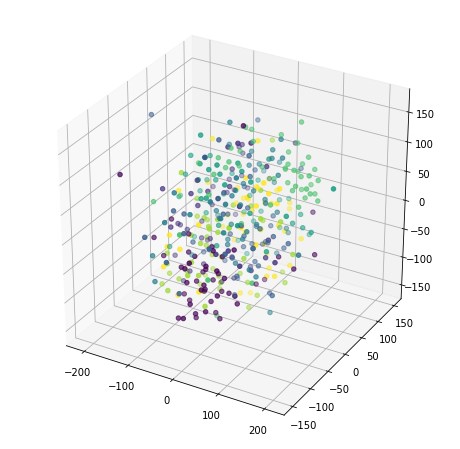

In [148]:
# Compute TSNE for different features and create a scatter plot
tsne_X = X # feature 
k = 3 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components = k).fit_transform(tsne_X)

# X_train, X_test, y_train, y_test = train_test_split(X_TSNE, y)

# Plot the representation in 2d/3d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], X_TSNE[:,2],c=y)
plt.show()

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


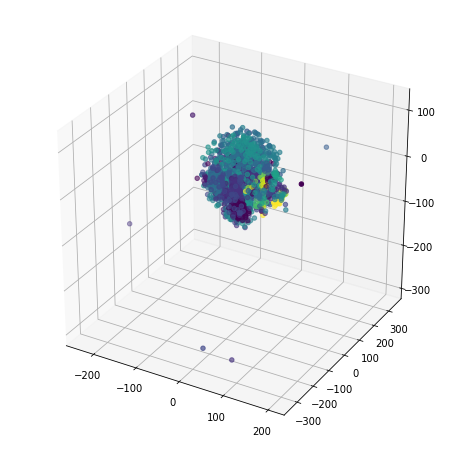

In [149]:
# Combined
cfw_X, cfw_y = load_data('./dataset/IIIT-CFW/')
cfw_N, cfw_H, cfw_W = cfw_X.shape[0:3]
cfw_C = 1 if opt['is_grayscale'] else cfw_X.shape[3]

imfdb_X, imfdb_y = load_data('./dataset/IMFDB/')
imfdb_N, imfdb_H, imfdb_W = imfdb_X.shape[0:3]
imfdb_C = 1 if opt['is_grayscale'] else imfdb_X.shape[3]

yale_X, yale_y = load_data('./dataset/Yale_face_database/')
yale_N, yale_H, yale_W = yale_X.shape[0:3]
yale_C = 1 if opt['is_grayscale'] else yale_X.shape[3]

cfw_X = cfw_X.reshape((cfw_N, cfw_H*cfw_W*cfw_C))
imfdb_X = imfdb_X.reshape((imfdb_N, imfdb_H*imfdb_W*imfdb_C))
yale_X = yale_X.reshape((yale_N, yale_H*yale_W*yale_C))

combined_X = np.concatenate((cfw_X, np.concatenate((imfdb_X, yale_X))))
combined_y = np.concatenate((cfw_y, np.concatenate((imfdb_y, yale_y))))

tsne_X = combined_X # feature 
k = 3 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components = k).fit_transform(tsne_X)

# X_train, X_test, y_train, y_test = train_test_split(X_TSNE, y)

# Plot the representation in 2d/3d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], X_TSNE[:,2],c=combined_y)
plt.show()

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

- *The dataset is first split into train and test set*
- *The train set is reduced to a lower space by doing dimensionality reduction and the matrix*
- *The reduced matrix is obtained. Reduced matrix will transform the features in the orginal space into the reduced space.*
- *The classifier is trained on the trainset in the reduced dimensions.*
- *For classification we use KNN algorithm*
- *Here we select the neighbours with the maximum votes by comuting the Euclidean distance between the reduced query data sample and the reduced train dataset points.*
- *By performing dimensionality reduction we hope that the latent features that really matter are compared for similarity*

_________________________________________________________

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

*For analyzing the performance of the classifier we use the recall and precision rather than just accuracy. Accuracy can give misleading results. This is because whenever true positives are less than false positives, the accuracy will always increase if the classifier was to always output negetive. For this case we look at precision and f-score to measure accuacy. We train
our classifier for different values of K neighbours and pick the one that performs the best on the
validation set.*


4(c)Show empirical results  with  all  the  representations

In [150]:
class FaceVerification():
    def __init__(self, k):
        # super().__init__()
        self.classifier = KNeighborsClassifier(n_neighbors=k, weights='distance')
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        predictions = self.classifier.predict(X)
        verification_results = (class_id == predictions)
        return verification_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classifier.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        # Create a confusion matrix
        predictions = self.classifier.predict(X_validate)
        conf_matrix = confusion_matrix(predictions, y_validate)
        
        # Calculate Classification Error
        classification_error = 0
        for i in range(len(predictions)):
            if predictions[i] != y_validate[i]:
                classification_error += 1
        # Calculate Validation accuracy 
        validation_accuracy = accuracy_score(y_validate, predictions)

        # Calculate precision and recall 
        precision, recall, _, _ = precision_recall_fscore_support(y_validate, predictions)
      
        # Calculate F1-score
        f_score = f1_score(y_validate, predictions, average='weighted')
        
        return conf_matrix, validation_accuracy, precision, recall, f_score, classification_error

In [151]:
# Create a train and validation split and show your results
K = [15, 30, 80]
k_values = []
confusion_matrices = []
validation_accuracies = []
precisions = []
recalls = []
f1_scores = []
classification_errors = []

for current_k in K:
    for i in range(len(training_data)):
        classifier = FaceVerification(k=current_k)
        classifier.train(training_data[i], label_data_train[i])
        verification = classifier.verify(testing_data[i], label_data_test[i])
        c, v, p, r, f, e = classifier.validate(testing_data[i], label_data_test[i])
        confusion_matrices.append(c)
        validation_accuracies.append(v)
        precisions.append(np.mean(p))
        recalls.append(r)
        f1_scores.append(f)
        classification_errors.append(e)
        k_values.append(current_k)
        print('Verification for {0}, for k = {1}:'.format(feature_names[i], current_k))
        print(verification)

Verification for PCA, for k = 15:
[False False False  True False False  True False False  True False  True
 False False False  True False  True  True False  True False False  True
  True  True  True False False  True False False False False False  True
 False False  True  True False  True  True False False  True  True False
 False  True  True  True False False False  True  True False False False
 False False False  True False  True False  True  True  True  True  True
  True False False  True  True  True  True  True False  True False  True
  True  True False False  True False  True  True  True  True  True False
  True False False False]
Verification for Kernel PCA, for k = 15:
[False False False  True  True False  True False False  True  True  True
 False False  True  True False  True False False  True False False  True
  True  True False False False  True False False False False False  True
 False False False  True False  True  True False False  True  True False
 False  True  True  Tru

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Verification for Resnet, for k = 15:
[ True  True  True  True  True  True False  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Verification for VGG, for k = 15:
[False  True  True  True  True False  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True False False False  True  True  True  True  True  True  True  True
  True  True  True  True  T

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Verification for Resnet, for k = 30:
[ True  True  True  True  True  True False  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Verification for VGG, for k = 30:
[False  True  True  True  True False  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True False False False  True  True  True  True  True  True  True  True
  True  True  True  True  T

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sk

Verification for Resnet, for k = 80:
[ True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Verification for VGG, for k = 80:
[False  True  True  True  True False  True  True  True  True False  True
  True False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True False False  True  True  True  True  True  True  True  True
  True  True False  True  T

In [152]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
feature_sizes = [pca_X_train.shape[1], kernel_pca_X_train.shape[1], lda_X_train.shape[1], kernel_lda_X_train.shape[1], resnet_X_train.shape[1], vgg_X_train.shape[1]]
confusion_matrices = np.array(confusion_matrices)
validation_accuracies = np.array(validation_accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)
classification_errors = np.array(classification_errors)

In [153]:
if dirpath == yale_face_database_name:
    yale_face_database_table = pd.DataFrame({
        'Feature': [*feature_names, *feature_names, *feature_names],
        'K Value': k_values,
        'Dimensionality': [*feature_sizes, *feature_sizes, *feature_sizes],
        'Verification Error': classification_errors,
        'Accuracy': validation_accuracies,
        'Precision': precisions
    })
    print('Yale Face Database:')
    display(HTML(yale_face_database_table.to_html()))

In [154]:
if dirpath == imfdb_name:
    imfdb_table = pd.DataFrame({
        'Feature': [*feature_names, *feature_names, *feature_names],
        'K Value': k_values,
        'Dimensionality': [*feature_sizes, *feature_sizes, *feature_sizes],
        'Verification Error': classification_errors,
        'Accuracy': validation_accuracies,
        'Precision': precisions
    })
    print('IMFDB: ')
    display((imfdb_table))

IMFDB: 


,Feature,K Value,Dimensionality,Verification Error,Accuracy,Precision
0,PCA,15,135,51,0.49,0.540208
1,Kernel PCA,15,20,56,0.44,0.470238
2,LDA,15,7,28,0.72,0.730667
3,Kernel LDA,15,7,82,0.18,0.201895
4,Resnet,15,2048,4,0.96,0.955266
5,VGG,15,4096,11,0.89,0.895177
6,PCA,30,135,62,0.38,0.439350
7,Kernel PCA,30,20,61,0.39,0.355357
8,LDA,30,7,28,0.72,0.731872
9,Kernel LDA,30,7,82,0.18,0.201895


In [155]:
if dirpath == iiit_cfw_name:
    iiit_cfw_table = pd.DataFrame({
        'Feature': [*feature_names, *feature_names, *feature_names],
        'K Value': k_values,
        'Dimensionality': [*feature_sizes, *feature_sizes, *feature_sizes],
        'Verification Error': classification_errors,
        'Accuracy': validation_accuracies,
        'Precision': precisions
    })    
    print('IIIT-CFW: ')
    display((iiit_cfw_table))

### Extension / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

#### Problem : Real vs Cartoon Images
*The selected problem is not trivial as the features from the dataset need to be extracted such that we can differentiate between a real image of the person and a cartoon. This becomes especially difficult in cases of comparison of realistic drawings and the image of a real person. We need to extract the patterns in wide range of varying faces, with all kinds of profiles and deformed shapes, in the cartoon database to identify it as cartoon while differentiating them from the noisy real images (from IMFDB) by getting the patterns from real images.*

#### Applications
- *Identification of fake/satirical content from real content on social media, news channels and newspapers. Also can be used for comic extraction from newspapers.*
- *The classifier can help in collection of new cartoon/comic data by differentiating between real and the cartoon images.*
- *Noise removal in data, where either one of the classes are irrelevant/noisy data points.*

#### Pipeline
- *Create dataset by combining cartoon images from IIIT-CFW and real images from IMFDB and the Yale face database.*
- *Split the dataset into train and validation set.*
- *Extract relevant features for the classification using dimensionality reduction techniques.*
- *Resnet features gave 100% accuracy most of the time and never fell below 95%. It seems to be the best suited for the problem.*
- *Train MLP classifier, using the dimensionality reduced training data, with different hidden layer sizes.*
- *Perform K-Fold validation to test the performance of the classifier on different data points.*
- *Check various metrics for analysis and choose best classifier.*



In [156]:
# Load data
cfw_X, cfw_y = load_data('./dataset/IIIT-CFW/')
cfw_N, cfw_H, cfw_W = cfw_X.shape[0:3]
cfw_C = 1 if opt['is_grayscale'] else cfw_X.shape[3]

imfdb_X, imfdb_y = load_data('./dataset/IMFDB/')
imfdb_N, imfdb_H, imfdb_W = imfdb_X.shape[0:3]
imfdb_C = 1 if opt['is_grayscale'] else imfdb_X.shape[3]

yale_X, yale_y = load_data('./dataset/Yale_face_database/')
yale_N, yale_H, yale_W = yale_X.shape[0:3]
yale_C = 1 if opt['is_grayscale'] else yale_X.shape[3]

Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


In [157]:
cfw_X = cfw_X.reshape((cfw_N, cfw_H*cfw_W*cfw_C))
imfdb_X = imfdb_X.reshape((imfdb_N, imfdb_H*imfdb_W*imfdb_C))
yale_X = yale_X.reshape((yale_N, yale_H*yale_W*yale_C))

In [158]:
y = np.concatenate((-1 * np.ones(cfw_y.shape[0]), np.ones(imfdb_y.shape[0] + yale_y.shape[0])))
X = np.concatenate((cfw_X, np.concatenate((imfdb_X, yale_X))))

In [159]:
# Define your features
cfw_resnet = get_resnet_features('./dataset/IIIT-CFW/')
imfdb_resnet = get_resnet_features('./dataset/IMFDB/')
yale_resnet = get_resnet_features('./dataset/Yale_face_database/')
resnet_X = np.concatenate((cfw_resnet, np.concatenate((imfdb_resnet, yale_resnet))))

X_train, X_test, y_train, y_test = train_test_split(resnet_X, y)

In [160]:
# Create your classifier
classifier = Classifier(hidden_size=(100, 250, 40), activation='tanh')

# Train classifier
classifier.train(X_train, y_train)

# Validate your classifier
conf_matrix, validation_accuracy, precision, recall, f_score, classification_error = classifier.validate(X_test, y_test)
print('Accuracy: {}%'.format(validation_accuracy * 100.0))

Accuracy: 100.0%


In [161]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
k_fold_validation = KFold(n_splits=15)
validation_accuracies =[]
for train_set, test_set in k_fold_validation.split(resnet_X):
    classifier.train(resnet_X[train_set], y[train_set])
    conf_matrix, validation_accuracy, precision, recall, f_score, classification_error = classifier.validate(resnet_X[test_set], y[test_set])
    validation_accuracies.append(validation_accuracy)
    bool_array = classifier.verify(resnet_X[test_set], y[test_set])
    accurate = np.where(bool_array == True)[0]
    mistakes = np.where(bool_array == False)[0]

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarni

In [162]:
print('Accuracy: {}%'.format(np.mean(validation_accuracies) * 100.0))

Accuracy: 74.18160446664707%


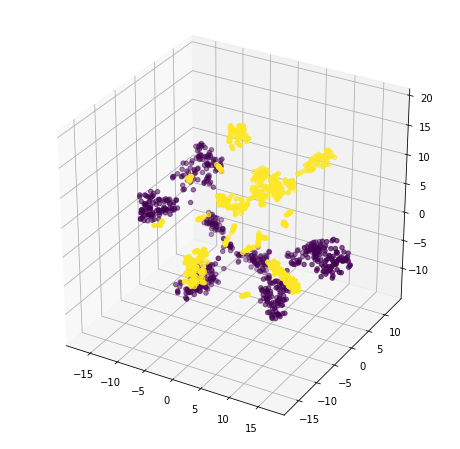

In [163]:
tsne_X = resnet_X # feature 
k = 3 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components = k).fit_transform(tsne_X)

# X_train, X_test, y_train, y_test = train_test_split(X_TSNE, y)

# Plot the representation in 2d/3d
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0], X_TSNE[:,1], X_TSNE[:,2],c=y)
plt.show()

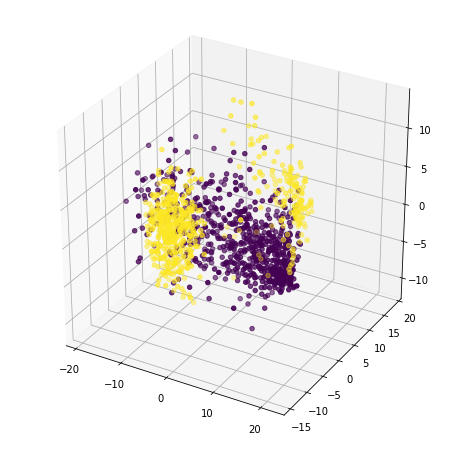

In [164]:
pca, pca_model = get_pca(X, 3)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca[:,0], pca[:,1], pca[:,2],c=y)
plt.show()

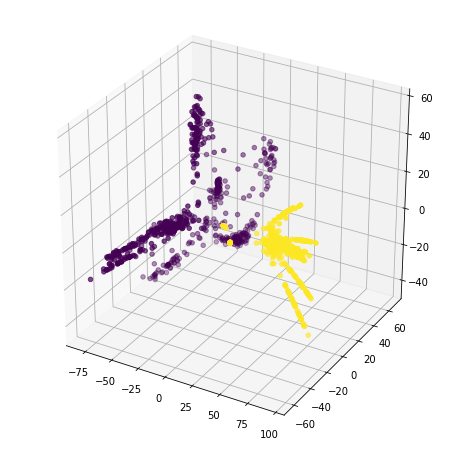

In [165]:
isomap = Isomap(n_components=3).fit_transform(resnet_X)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(isomap[:,0], isomap[:,1], isomap[:,2], c=y)
plt.show()

Correct Classification Example: 


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


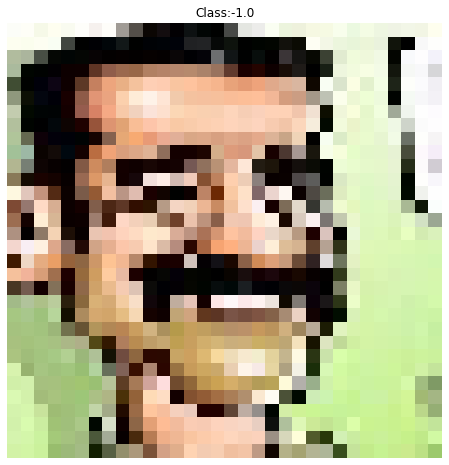

Incorrect Classification Example: 


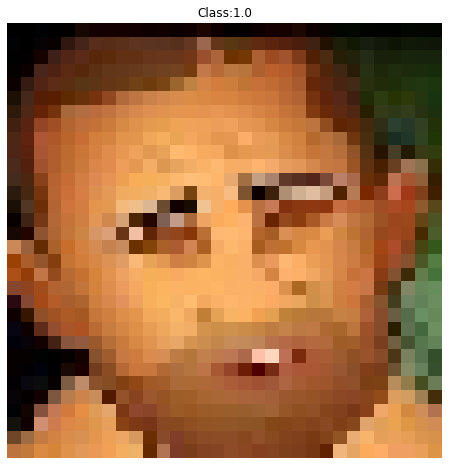

Correct Classification Example: 


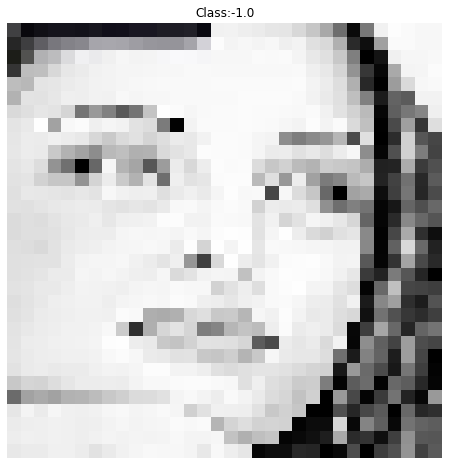

Correct Classification Example: 


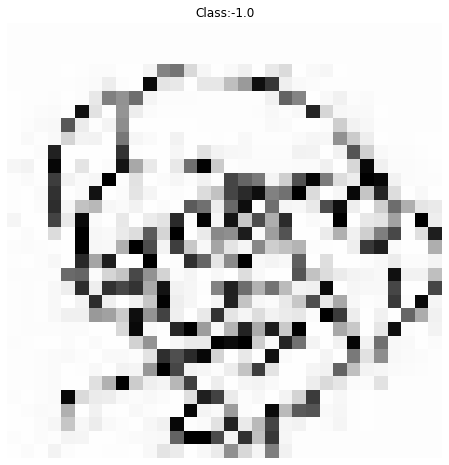

Correct Classification Example: 


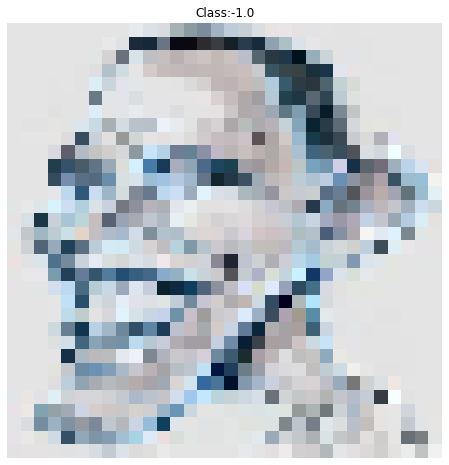

Correct Classification Example: 


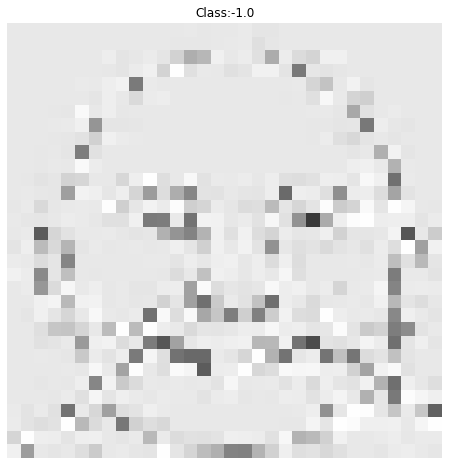

Correct Classification Example: 


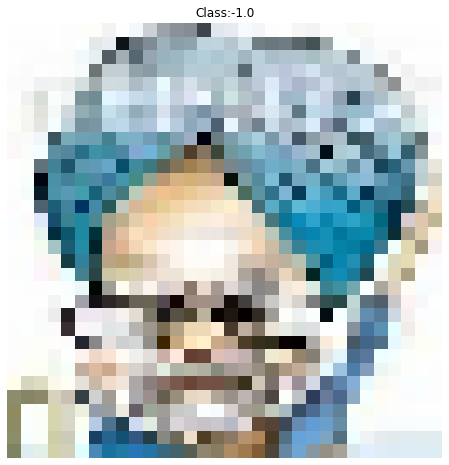

Correct Classification Example: 


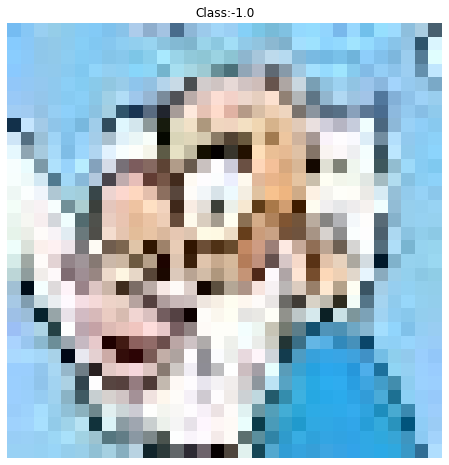

Correct Classification Example: 


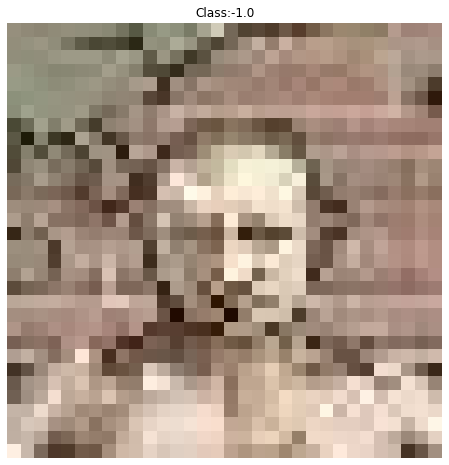

Correct Classification Example: 


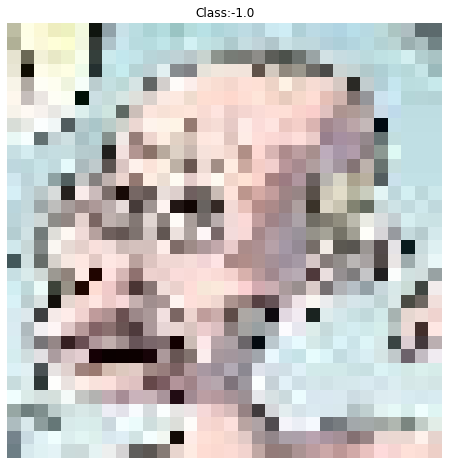

Incorrect Classification Example: 


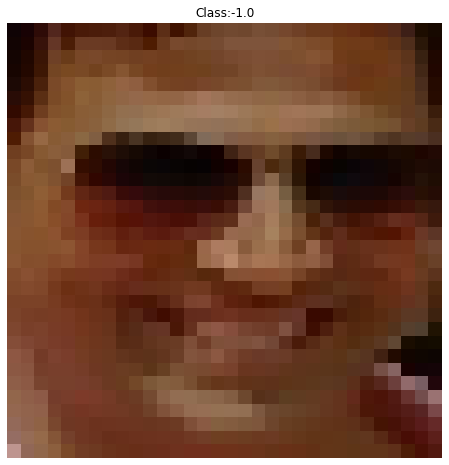

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Correct Classification Example: 


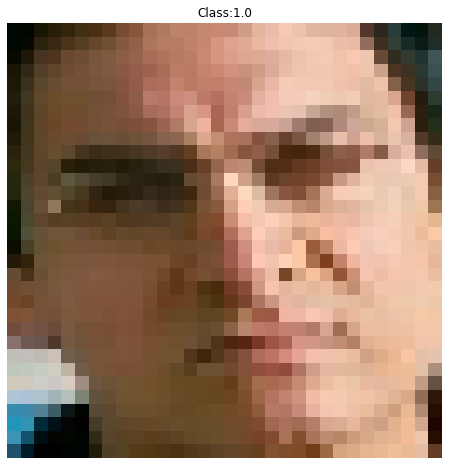

Incorrect Classification Example: 


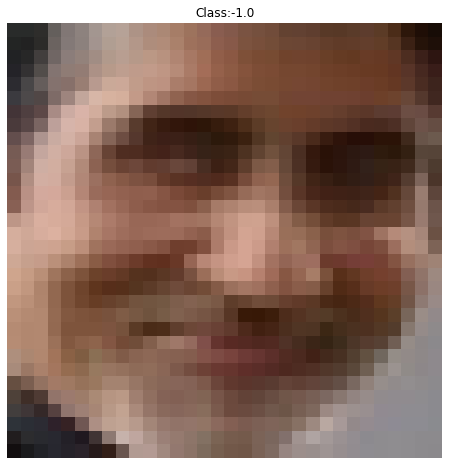

Correct Classification Example: 


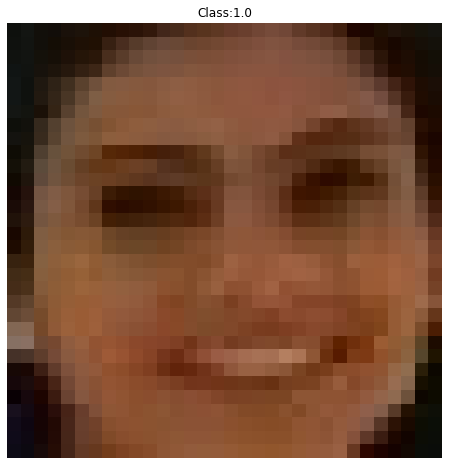

Correct Classification Example: 


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


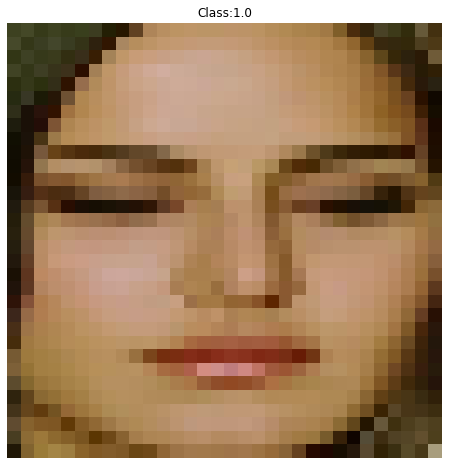

Incorrect Classification Example: 


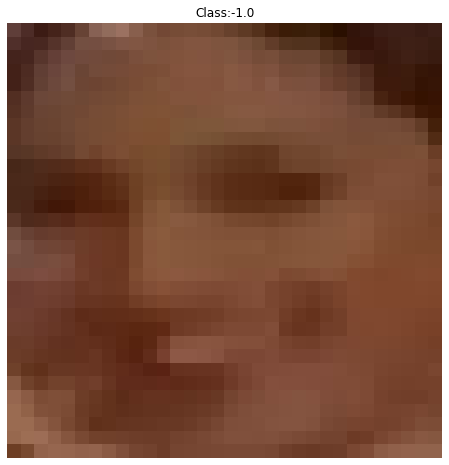

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Correct Classification Example: 


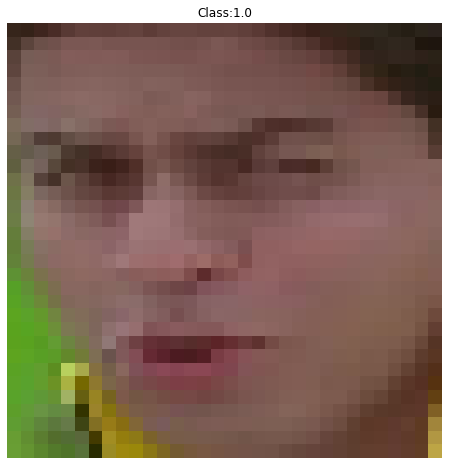

Incorrect Classification Example: 


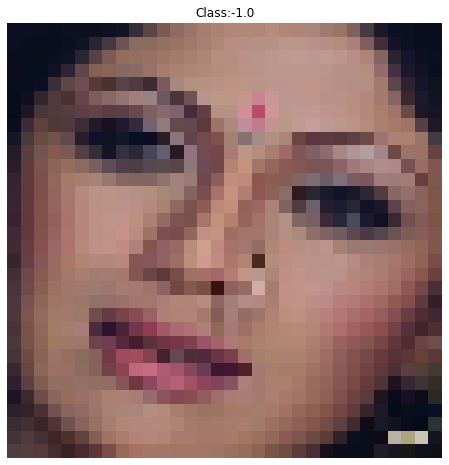

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Correct Classification Example: 


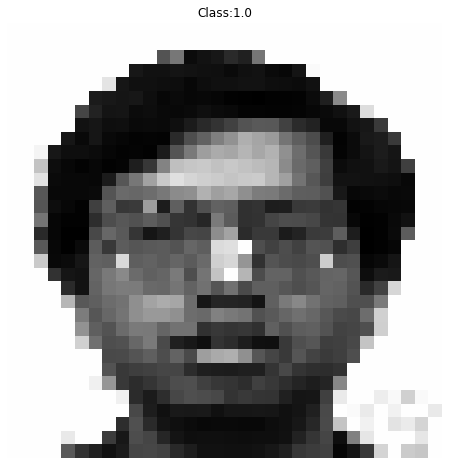

Incorrect Classification Example: 


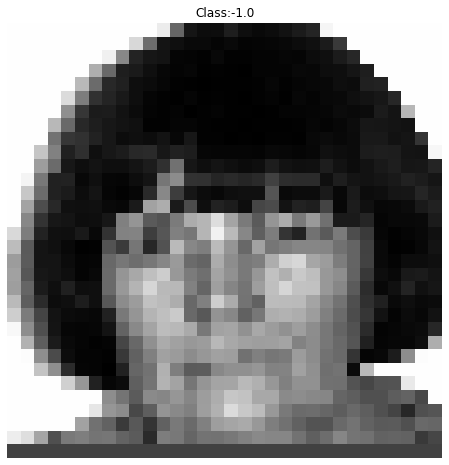

Correct Classification Example: 


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


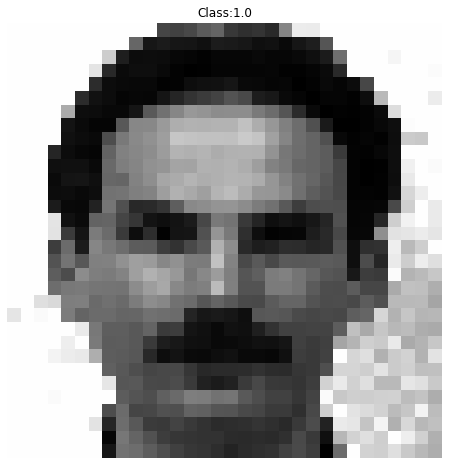

Incorrect Classification Example: 


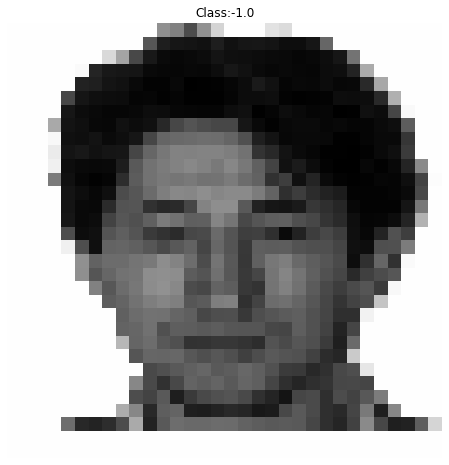

In [166]:
# Show quantitative results such as examples of correct prediction and wrong prediction
for train_set, test_set in k_fold_validation.split(resnet_X):
    classifier.train(resnet_X[train_set], y[train_set])
    conf_matrix, validation_accuracy, precision, recall, f_score, classification_error = classifier.validate(resnet_X[test_set], y[test_set])
    bool_array = classifier.verify(resnet_X[test_set], y[test_set])
    accurate = np.where(bool_array == True)[0]
    mistakes = np.where(bool_array == False)[0]
    print('Correct Classification Example: ')
    disply_images(X[test_set][accurate[:1]].reshape((1, 32, 32, 3)), y[test_set][accurate[:1]], row=1, col=1)
    if len(mistakes > 0):
        print('Incorrect Classification Example: ')
        disply_images(X[test_set][mistakes[:1]].reshape((1, 32, 32, 3)), -1 * y[test_set][mistakes[:1]], row=1, col=1)